# # Training The RNN model

In [389]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.stem import PorterStemmer
import text_hammer as th

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/home/blank/new_work_2023/training_lab/src')
from es_vuln_extraction import tools
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

gpus = tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(gpus[1], 'GPU')

df = pd.read_csv("../data/stage6/data-set_v3.csv", encoding_errors="ignore")
dftest = pd.read_csv('../data/test_data/unseen2.csv', encoding_errors='ignore')

# validation Data
dfvalid = pd.read_csv('../data/stage6/data-set_v3.csv', encoding_errors='ignore')



df = df.dropna()
dftest = dftest.dropna()
dfvalid = dfvalid.dropna()

print(f"training dataset details:")
print(df.label.value_counts())
print(f"test dataset details:")
print(dftest.label.value_counts())
print(f"validation dataset details:")
print(dfvalid.label.value_counts())

# convert label to a numerical variable
#cleaned_df['label'] = cleaned_df.label.map({'es':0, 'classic':1, 'uncertain': 2})
df['label'] = df.label.map({'es':0, 'classic':1})

#cleaned_dftest['label'] = cleaned_dftest.label.map({'es':0, 'classic':1})
dftest['label'] = dftest.label.map({'es':0, 'classic':1, 'ambiguous': 2})

dfvalid['label'] = dfvalid.label.map({'es':0, 'classic':1})
#df_valid['label'] = df_valid.label.map({'es':0, 'classic':1})


training dataset details:
classic    992
es         737
Name: label, dtype: int64
test dataset details:
classic      57
es           56
ambiguous    54
Name: label, dtype: int64
validation dataset details:
classic    992
es         737
Name: label, dtype: int64


In [390]:
stop_words = set(stopwords.words("english"))
tqdm.pandas()
ps = PorterStemmer()

def remove_stopwords(text):
    try:
        return " ".join([word for word in text.split() if word not in stop_words])
    except AttributeError:
        print(text)

def text_preprocessing(df,col_name):
    column = col_name
    #df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: remove_stopwords(x))
    #df[column] = df[column].progress_apply(lambda x: th.remove_common_words(x, ['allow']))#, 'user', 'allow', 'service', 'version', 'file', 'attacker', 'arbitrary', 'cause', 'execute', 'denial']))
    df[column] = df[column].progress_apply(lambda x: ps.stem(x))
    #df[column] = df[column].progress_apply(lambda x: lemmatizing(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    
    #df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    #df[column] = df[column].progress_apply(lambda x: re.sub(r'[^\w\s//-]', '', x))
    return(df)

In [391]:
prep_df = text_preprocessing(df, "text")
prep_dftest = text_preprocessing(dftest, "text")
prep_dfvalid = text_preprocessing(dfvalid, "text")

100%|██████████| 1729/1729 [00:00<00:00, 53595.49it/s]


In [74]:
all_data = []
i = 0
for i in range(7):
    data_ambiguous = pd.read_csv(f"../data/stage{i}/ambigous_data.csv")
    data_set = pd.read_csv(f"../data/stage{i}/data-set_v3.csv")
    all_data.append(data_set)
    all_data.append(data_ambiguous)


data_test = pd.read_csv(f"../data/test_data/unseen_data.csv")
all_data.append(data_test)
all_data = pd.concat(all_data)
all_data = all_data.dropna()


In [243]:
null_mask = cleaned_df.isnull().any(axis=1)
row_indices = np.where(null_mask)[0]

# Print the row indices
print(row_indices)

[]


In [345]:
prep_df

,text,label
0,buffer overflow windows shell used windows des...,1
1,apple filing protocol afp server apple mac os ...,1
2,unspecified vulnerability appkit apple mac os ...,1
3,integer overflow cfdatareplacebytes function c...,1
4,coregraphics apple mac os x 1053 allows remote...,1
...,...,...
1724,mp c2004ex digital composite ricoh china inves...,0
1725,ricoh china investment co ltd offers services ...,0
1726,samsung galaxy s10 new generation smartphone f...,0
1727,huawei m6 equipped flagship kirin 980 processo...,0


In [226]:
null_mask = prep_dftest.isnull().any(axis=1)
row_indices = np.where(null_mask)[0]

# Print the row indices
print(row_indices)

[]


In [346]:
dftest

,text,label
0,the affected products vulnerable improper vali...,2
1,the affected products vulnerable integer overf...,2
2,the affected products vulnerable directory tra...,2
3,the affected products vulnerable untrusted dat...,2
4,remote procedure call runtime remote code exec...,2
...,...,...
164,heapbased buffer overflow apple type services ...,1
165,integer underflow coregraphics apple mac os x ...,1
166,launch services apple mac os x 10411 105 1057 ...,1
167,heapbased buffer overflow cfnetwork apple mac ...,1


In [347]:
import nltk
### Calculating the word frequency by using nltk
words_list = []
for sentence in prep_df.text:
    words_list.extend(nltk.word_tokenize(sentence))
freq_dist = nltk.FreqDist(words_list)
freq_dist.most_common(100)
#print(freq_dist.keys())

[('vulnerability', 1532),
 ('windows', 1011),
 ('remote', 709),
 ('allows', 687),
 ('code', 656),
 ('attacker', 618),
 ('via', 609),
 ('the', 587),
 ('this', 583),
 ('microsoft', 553),
 ('attackers', 537),
 ('crafted', 530),
 ('arbitrary', 499),
 ('affected', 498),
 ('a', 494),
 ('could', 481),
 ('an', 475),
 ('ios', 393),
 ('server', 382),
 ('memory', 379),
 ('issue', 373),
 ('execute', 371),
 ('information', 367),
 ('software', 365),
 ('exploit', 358),
 ('cisco', 350),
 ('aka', 345),
 ('versions', 343),
 ('device', 338),
 ('allow', 323),
 ('service', 316),
 ('execution', 316),
 ('cause', 302),
 ('may', 286),
 ('application', 280),
 ('prior', 260),
 ('oracle', 258),
 ('users', 248),
 ('denial', 245),
 ('system', 245),
 ('file', 238),
 ('servers', 227),
 ('user', 225),
 ('sensitive', 224),
 ('access', 224),
 ('os', 223),
 ('office', 222),
 ('exists', 220),
 ('apple', 209),
 ('web', 208),
 ('10', 205),
 ('sd', 199),
 ('obtain', 191),
 ('privileges', 191),
 ('addressed', 191),
 ('vulnera

In [349]:
df['word_length'] = df['text'].apply(lambda x:len(x.split()))

In [350]:
df.word_length.max()

365

In [392]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(prep_df.text, prep_df.label, test_size = 0.2 , shuffle=True, random_state=42)

print(y_train.value_counts())

def split_valid_data(df):
    labeles = df.label
    text = df.text
    return (text, labeles)

X_fix, y_fix = split_valid_data(prep_dftest)
X_valid, y_valid = split_valid_data(prep_dfvalid)

1    797
0    586
Name: label, dtype: int64


In [78]:
from keras.preprocessing.text import Tokenizer
num_words = 40000 # this means 15000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
#df_total = pd.concat([X_train, X_test, X_valid, X_eval], axis = 0)
tokenizer.fit_on_texts(prep_all_data.text)

In [10]:
import pickle
#pickle.dump(tokenizer, open("../data/tokenizer/prep_tokenizer.pickle", "wb+"))

In [393]:
# loading
with open('../data/tokenizer/prep_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

len(tokenizer.word_index) # this is whole unique words in our corpus
# but we have taken 10000 but we have only 8502 and the rest will be zero

num_words = len(tokenizer.word_index)

X_train_ = tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=600, padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 600, padding = 'post')
X_fix_ = tokenizer.texts_to_sequences(X_fix)
X_fix_pad = pad_sequences(X_fix_, maxlen = 600, padding = 'post')

print(X_train_pad)

[[   43     1    56 ...     0     0     0]
 [  382   138  5762 ...     0     0     0]
 [ 2771   329   844 ...     0     0     0]
 ...
 [  382   138  1023 ...     0     0     0]
 [  619   621 27921 ...     0     0     0]
 [   27    23    75 ...     0     0     0]]


# Implimentation of LSTM using pytorch

In [233]:
print(X_train_pad.shape,X_test_pad.shape) # this is our 2D matrix we can take this as Input data

(1384, 600) (347, 600)


In [97]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding,Bidirectional
from keras.layers import CuDNNLSTM,CuDNNGRU
from keras.layers import Dropout
import gensim.downloader as api

glove_sim = api.load("glove-wiki-gigaword-300")
#w2v_sim = api.load("word2vec-google-news-300")
#ft_sim = api.load("fasttext-wiki-news-subwords-300")

In [303]:
# now lets connvert all the words we have in our data into vectors 
vector_size = 300
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape
# count number of exist words in glove
num_words_count = 0
for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_sim.key_to_index:
            gensim_weight_matrix[index] = glove_sim[word]
            num_words_count = num_words_count +1
        #else:
        #    gensim_weight_matrix[index] = np.zeros(vector_size)

In [339]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#stage = str(input("what is the stage you want to store the model into. Check very well!: "))
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint("../data/stage6/models/2_class_scenario.h5", monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [179]:
EMBEDDING_DIM = 300
model_gensim = Sequential()
model_gensim.add(Embedding(
    input_dim=num_words,
    output_dim=EMBEDDING_DIM,
    input_length=X_train_pad.shape[1],
    weights=[gensim_weight_matrix],
    trainable=False
))
model_gensim.add(Bidirectional(
    CuDNNLSTM(200, return_sequences=True)
))
model_gensim.add(Dropout(0.3))
model_gensim.add(Bidirectional(
    CuDNNLSTM(200, return_sequences=False)
))
model_gensim.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_gensim.add(Dropout(0.3))
model_gensim.add(Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_gensim.add(Dropout(0.3))
model_gensim.add(Dense(1, activation='sigmoid', kernel_initializer='he_uniform'))
model_gensim.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_gensim.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 600, 300)          10265100  
                                                                 
 bidirectional_10 (Bidirecti  (None, 600, 400)         803200    
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 600, 400)          0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 400)              963200    
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 128)               51328     
                                                                 
 dropout_16 (Dropout)        (None, 128)              

In [180]:
history_gensim = model_gensim.fit(X_train_pad,y_train, epochs = 20, batch_size = 32, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/20
62/62 [==============================] - ETA: 0s - loss: 2.6201 - accuracy: 0.8614
Epoch 1: val_accuracy improved from -inf to 0.93333, saving model to ../data/stage0/models/2_class_scenario.h5
62/62 [==============================] - 32s 419ms/step - loss: 2.6201 - accuracy: 0.8614 - val_loss: 1.3402 - val_accuracy: 0.9333
Epoch 2/20
62/62 [==============================] - ETA: 0s - loss: 0.8302 - accuracy: 0.9611
Epoch 2: val_accuracy did not improve from 0.93333
62/62 [==============================] - 25s 397ms/step - loss: 0.8302 - accuracy: 0.9611 - val_loss: 0.5622 - val_accuracy: 0.9333
Epoch 3/20
62/62 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.9605
Epoch 3: val_accuracy improved from 0.93333 to 0.95556, saving model to ../data/stage0/models/2_class_scenario.h5
62/62 [==============================] - 25s 408ms/step - loss: 0.3703 - accuracy: 0.9605 - val_loss: 0.2813 - val_accuracy: 0.9556
Epoch 4/20
62/62 [============================

#### continuous training

In [340]:
# Load the old model
prev_model = keras.models.load_model("../data/stage5/models/2_class_scenario.h5")

In [341]:

prev_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_gensim = prev_model.fit(X_train_pad,y_train, epochs = 50, batch_size = 32, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9776
Epoch 1: val_accuracy improved from -inf to 0.98555, saving model to ../data/stage6/models/2_class_scenario.h5
44/44 [==============================] - 24s 414ms/step - loss: 0.0859 - accuracy: 0.9776 - val_loss: 0.0842 - val_accuracy: 0.9855
Epoch 2/50
44/44 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9920
Epoch 2: val_accuracy did not improve from 0.98555
44/44 [==============================] - 17s 395ms/step - loss: 0.0514 - accuracy: 0.9920 - val_loss: 0.0714 - val_accuracy: 0.9855
Epoch 3/50
44/44 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9957
Epoch 3: val_accuracy did not improve from 0.98555
44/44 [==============================] - 17s 398ms/step - loss: 0.0422 - accuracy: 0.9957 - val_loss: 0.0962 - val_accuracy: 0.9798
Epoch 4/50
44/44 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9935
Epoch 4: val_ac

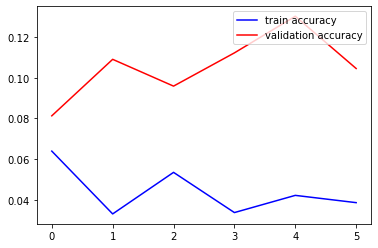

In [325]:
# lets draw learning curve 
import matplotlib.pyplot as plt
plt.plot(history_gensim.history['loss'],c='b',label='train accuracy')
plt.plot(history_gensim.history['val_loss'],c='r',label='validation accuracy')
plt.legend(loc='upper right')
plt.show()

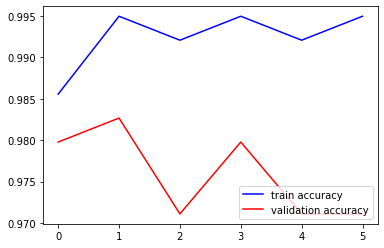

In [326]:
# lets draw learning curve 
import matplotlib.pyplot as plt
plt.plot(history_gensim.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_gensim.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [396]:
prev_model = keras.models.load_model("../data/stage6/models/2_class_scenario.h5")

In [328]:
prev_model.evaluate(X_test_pad, y_test)

11/11 [==============================] - 2s 150ms/step - loss: 0.1090 - accuracy: 0.9827


[0.10903023183345795, 0.9826589822769165]

In [329]:
y_pred = prev_model.predict(X_test_pad)
tools.save_to_excel(y_pred, y_test, "../data/stage5/test_results/2_class_scenario_metrics_test")

11/11 [==============================] - 2s 146ms/step


/home/blank/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [397]:
accuracy = prev_model.evaluate(X_fix_pad, y_fix)[1]
file1 = open("../data/stage0/validation_results/ambiguous_scenario_fix_v2.txt", "w+")
file1.write(f"accuracy = {accuracy}")
file1.close()

6/6 [==============================] - 2s 144ms/step - loss: -0.2113 - accuracy: 0.6467


In [246]:
accuracy

0.9383207559585571

In [563]:
import re
def text_preprocessing2(text):
    text1 = lambda x:str(x).lower()
    s = text1(text)
    text2 = lambda x: th.cont_exp(x) #you're -> you are; i'm -> i am
    s = text2(s)
    text3 = lambda x: th.remove_emails(x)
    s = text3(s)
    text4 = lambda x: th.remove_html_tags(x)
    s = text4(s)
    text5 = lambda x: remove_stopwords(x)
    s = text5(s)
    #text9 = lambda x: th.remove_common_words(x, ['allow'])#,'user', 'allow', 'service', 'version', 'file', 'attacker', 'arbitrary', 'cause', 'execute', 'denial'])
    #s = text9(s)
    #text10 = lambda x: lancaster.stem(x)
    #s = text10(s)
#     df[column] = df[column].progress_apply(lambda x:th.spelling_correction(x))
    #text6 = lambda x: th.remove_special_chars(x)
    #s = text6(s)
    text7 = lambda x: th.remove_accented_chars(x)
    s = text7(s)
    #text8 = lambda x: th.make_base(x) #ran -> run,
    #s = text8(s)
    #text9 = lambda x: re.sub(r'[0-9]+', '', x)
    #s = text9(s)
    return(s)

In [189]:
def predict(sentence):
    sentence_lst=[]
    sentence_lst.append(sentence)
    sentence_seq=tokenizer.texts_to_sequences(sentence_lst)
    sentence_padded=pad_sequences(sentence_seq,maxlen=600,padding='post')
    probability = (prev_model.predict(sentence_padded))[0]
    print(probability)
    if probability*100 >= 50:
        return "es"
    elif probability*100 < 50:
        return "classic"
    elif probability == 2:
        return "ambiguous"
    else:
        return "Draw"

In [190]:
predict(input("your sentence: "))

1/1 [==============================] - 0s 74ms/step
[0.7031844]


'es'

In [113]:
X_valid

0       apache apple mac os x 1028 1036 allows remote ...
1       buffer overflow psnormalizer apple mac os x 10...
2       terminal apple mac os x 1036 may indicate secu...
3       postfix server apple mac os x 1036 using cramm...
4       unknown vulnerability apple mac os x 1036 serv...
                              ...                        
1726    axis it company provides online video solution...
1727    axis it company provides online video solution...
1728    axis it company provides online video solution...
1729    axis it company provides online video solution...
1730    axis it company provides online video solution...
Name: text, Length: 1731, dtype: object

In [398]:
# well i need to check the real label to see whether the model predict it right or wrong
# Those are supposed to be global varibales but somehow python doesn't like that at all
es_preds = {"text":[], "label":[]}
nes_preds = {"text":[], "label":[]}
ambiguous_preds = {"text":[], "label":[]}


def predict0(sentence, tlabel):
    global es_preds, nes_preds, ambiguous_preds

    sentence_seq=tokenizer.texts_to_sequences([sentence])
    sentence_padded=pad_sequences(sentence_seq,maxlen=600,padding='post')

    # Predict class probabilities
    probabilities = (prev_model.predict(sentence_padded))[0]

    # Find the class with the highest probability
    predicted_class = np.argmax(probabilities)
    max_probability = max(probabilities)

    if predicted_class == 0:
        target_dict = es_preds
    elif predicted_class == 1:
        target_dict = nes_preds
    else:
        target_dict = ambiguous_preds
    
    # Define your probability threshold here (e.g., 0.95)
    threshold = 0.5

    if max_probability < threshold:
        ambiguous_preds['text'].append(sentence)
        ambiguous_preds['label'].append(label)
    else:
        target_dict['text'].append(sentence)
        target_dict['label'].append(label)

# A dataframe to capture the prediction of our test data
from tqdm import tqdm
for (text, label) in zip(X_fix, y_fix):
    predict0(text, label)

TP = es_preds['label'].count(0)
FP = es_preds['label'].count(1) + es_preds['label'].count(2)
TN = nes_preds['label'].count(1)
FN = nes_preds['label'].count(0) + nes_preds['label'].count(2)

prediction_acc = (TP + TN) / (TP+TN+FP+FN)

# The percentage of ES NES predicted as ambiguous
ambig_len = len(ambiguous_preds['text'])
num_false_ambig = ambiguous_preds['label'].count(1) + ambiguous_preds['label'].count(0)

false_ambig_percent = (num_false_ambig * 100) / ambig_len


percent_of_ambiguous = (len(ambiguous_preds['text'])*100) / (TP+TN+FP+FN)

print(f"Generalization accuracy = {prediction_acc*100}%")
print(f"false ambiguous percentage = {false_ambig_percent}%")


1/1 [==============================] - 0s 63ms/step
Generalization accuracy = 4.2105263157894735%
false ambiguous percentage = 73.61111111111111%


In [388]:
ambiguous_preds

{'text': ['the affected products vulnerable improper validation array index could allow attacker crash server remotely execute arbitrary code',
  'the affected products vulnerable directory traversal may allow attacker obtain arbitrary operating system files',
  'the affected products vulnerable untrusted data due deserialization without prior authorizationauthentication may allow attacker remotely execute arbitrary code',
  'remote procedure call runtime remote code execution vulner',
  'internet control message protocol icmp remote code execution vulner',
  'http protocol stack remote code execution vulner',
  'information disclosure graphics gpu context switch',
  'prior apache http server 2455 malicious backend cause response headers truncated early resulting headers incorporated response body if later headers security purpose interpreted client',
  'the wwwdata apache web server account configured run sudo password many commands including binsh binbash',
  'a flaw found glibc an o

In [399]:
# well i need to check the real label to see whether the model predict it right or wrong
# Those are supposed to be global varibales but somehow python doesn't like that at all
es_preds = {"text":[], "label":[]}
nes_preds = {"text":[], "label":[]}
ambiguous_preds = {"text":[], "label":[]}


def predict0(sentence, tlabel):
    global es_preds, nes_preds, ambiguous_preds

    sentence_seq=tokenizer.texts_to_sequences([sentence])
    sentence_padded=pad_sequences(sentence_seq,maxlen=600,padding='post')

    # Predict class probabilities
    probabilities = (prev_model.predict(sentence_padded))[0]

    # Find the class with the highest probability
    #predicted_class = np.argmax(probabilities)
    #max_probability = max(probabilities)

    if probabilities*100 >= 50:
        target_dict = es_preds
    elif probabilities*100 < 50:
        target_dict = nes_preds
    
    # Define your probability threshold here (e.g., 0.95)
    #threshold = 0.5

    #if probabilities < threshold:
    #    ambiguous_preds['text'].append(sentence)
    #    ambiguous_preds['label'].append(label)
    #else:
    target_dict['text'].append(sentence)
    target_dict['label'].append(label)


# A dataframe to capture the prediction of our test data
from tqdm import tqdm
for (text, label) in zip(X_fix, y_fix):
    predict0(text, label)

TP = es_preds['label'].count(0)
FP = es_preds['label'].count(1) + es_preds['label'].count(2)
TN = nes_preds['label'].count(1)
FN = nes_preds['label'].count(0) + nes_preds['label'].count(2)

prediction_acc = (TP + TN) / (TP+TN+FP+FN)

# The percentage of ES NES predicted as ambiguous
#ambig_len = len(ambiguous_preds['text'])
#num_false_ambig = ambiguous_preds['label'].count(1) + ambiguous_preds['label'].count(0)

#false_ambig_percent = (num_false_ambig * 100) / ambig_len


#percent_of_ambiguous = (len(ambiguous_preds['text'])*100) / (TP+TN+FP+FN)

print(f"Generalization accuracy = {prediction_acc*100}%")
#print(f"false ambiguous percentage = {false_ambig_percent}%")


1/1 [==============================] - 0s 63ms/step
Generalization accuracy = 4.424778761061947%


In [200]:
prev_model.evaluate(X_fix_pad, y_fix)

158/158 [==============================] - 23s 145ms/step - loss: 0.4273 - accuracy: 0.9051


[0.4272504150867462, 0.9050934910774231]

In [193]:
print(f"Generalization accuracy = {prediction_acc*100}%")

Generalization accuracy = 8.416235575009948%


In [85]:
f = open(f"../data/stage0/validation_results/2_class_fix_data_results.txt", "w+")
f.write(f"generalization accuracy = {prediction_acc*100} \nAmbiguous precent per whole data = {percent_of_ambiguous}\npercentage of true ambiguous = {ambiguous_preds['label'].count(2)}")

f.close()

In [64]:
def get_uncertain(es_df, nes_df, unce_df, stage, cenario):
    
    # ES bar
    es_FP = es_df[es_df.label==1]
    es_TP = es_df[es_df.label==0]
    # NES_bar
    nes_FN = nes_df[nes_df.label==0]
    nes_TN = nes_df[nes_df.label==1]

    unce_20_percent = int((len(unce_df.label)*20)/100)
    es_20_percent = int((len(es_FP.label)*20)/100)
    nes_20_percent = int((len(nes_FN.label)*20)/100)

    unce_df = unce_df.sample(frac=1)
    _unce_df_20_ = unce_df.head(unce_20_percent)
    _unce_df_80_ = unce_df.tail(-unce_20_percent)

    es_FP_20 = es_FP.head(es_20_percent)
    es_FP_80 = es_FP.tail(-es_20_percent)

    nes_FN_20 = nes_FN.head(nes_20_percent)
    nes_FN_80 = nes_FN.tail(-nes_20_percent)

    # create uncertain
    uncertain = [es_FP_80, nes_FN_80, _unce_df_80_]
    uncertain = pd.concat(uncertain)

    # Relabel uncertain
    uncertain['label'] = uncertain["label"].progress_apply(lambda x: 'ambiguous')

    # create es and classic
    train_data = [es_TP, nes_TN, es_FP_20, nes_FN_20, _unce_df_20_]
    train_dataset = pd.concat(train_data)

    # Relabel es and classic
    train_dataset['label'] = train_dataset["label"].progress_apply(lambda x: 'es' if x == 0 else 'classic')

    # Concatinate es, classic and uncertain
    dataset = [train_dataset, uncertain]
    dataset = pd.concat(dataset)

    # save dataset into the next stage
    dataset.to_csv(f"../data/stage{stage + 1}/threshold_scenario_{cenario}.csv")

    return dataset


In [263]:
def dic_to_df(dic):
    dic_to_df = pd.DataFrame({'text':dic['text'], 'label':dic['label']})
    return dic_to_df

esdf = dic_to_df(es_preds)
nesdf = dic_to_df(nes_preds)
ambigdf = dic_to_df(ambiguous_preds)

In [344]:
def save_metrics_generalization(tp, tn, fp, fn, path):
    f1 = open(path, "w+")
    acc = (tp+tn)/(tp+tn+fp+fn)
    pre_es = tp/(tp+fp)
    pre_nes = tn/(tn+fn)
    f1.write("Accuracy: "+str(acc)+"\n"+"precision_es: "+str(pre_es)+"\n"+"precision_nes: "+str(pre_nes))
    f1.close() 


save_metrics_generalization(espreds['label'].count(0), nespreds['label'].count(1), 
                            espreds['label'].count(1), nespreds['label'].count(0), 
                            "../data/stage0/_generalization_metrics_test_95_v8.txt")

In [264]:
ambigdf.label.value_counts()

2    142
0      1
Name: label, dtype: int64

In [103]:
from tqdm import tqdm
tqdm.pandas()
get_uncertain(esdf, nesdf, ambigdf, 0, 50).label.value_counts()

100%|██████████| 1582/1582 [00:00<00:00, 707096.01it/s]


classic      879
es           703
ambiguous    145
Name: label, dtype: int64

In [139]:
import sys
sys.path.insert(1, '/home/blank/new_work_2023/training_lab/src')
from es_vuln_extraction import tools

uncertain_chatgpt = tools.f2l("../data/cnvd_data/script_iot_cnvd/script_iot_cnvd_2023.txt")
uncertain_forefont = tools.f2l("../data/cnvd_data/script_net_cnvd/script_net_cnvd_2023.txt")
uncertain_manual = tools.f2l("../data/cnvd_data/es_entries.txt")

In [140]:
data = []
data.extend(uncertain_chatgpt)
data.extend(uncertain_forefont)
data.extend(uncertain_manual)
len(data)

534

In [25]:
from collections import Counter
a = dict(Counter(uncertain_chatgpt))
a

{"The software's lack of input validation exposes a potential attack vector, allowing malicious actors to inject arbitrary code and compromise system integrity.": 1,
 'Inadequate access controls within the application create a security gap, enabling unauthorized users to gain privileged access and manipulate sensitive data.': 1,
 'The encryption algorithm used in the product is outdated and vulnerable to known cryptographic attacks, compromising the confidentiality of stored information.': 1,
 'Insufficient error handling mechanisms expose the system to potential denial-of-service attacks, allowing attackers to overload the product and disrupt its normal operation.': 1,
 'The default configuration settings in the software pose a security risk, as they do not adhere to recommended security best practices, leaving the product susceptible to unauthorized access.': 1,
 'A flaw in the authentication process allows attackers to bypass login mechanisms and gain unauthorized access to sensitiv

In [141]:
unique_data = list(dict.fromkeys(data))

In [142]:
len(unique_data)

399

In [143]:
tools.l2f(unique_data, "../data/cnvd_data/es_cnvd_2023.txt")

In [276]:
tech_data = pd.read_csv(f"../data/stage0/tech_entries_initial_third_class.csv")
data_set = pd.read_csv(f"../data/stage0/data-set_v3.csv")

data = [tech_data, data_set]

data = pd.concat(data)


In [278]:
data.to_csv("../data/stage0/threshold_scenario.csv")

In [240]:
import csv

for i in range(0, 7):
    ambig_data = pd.read_csv(f"../data/stage{i}/random_data.csv")
    data_set = pd.read_csv(f"../data/stage{i}/data-set_v3.csv")

    data = [ambig_data, data_set]
    data = pd.concat(data)
    data.to_csv(f"../data/stage{i}/random_scenario.csv", index=False)
    print(i)



0
1
2
3
4
5
6


In [239]:

ambig_data = pd.read_csv(f"../data/stage0/random_data.csv")
data_set = pd.read_csv(f"../data/stage1/data-set_v3.csv")
data = [ambig_data, data_set]
data = pd.concat(data)
data.head()

,text,label
0,The day had begun on a bright note. The sun fi...,random
1,It really didn't matter what they did to him. ...,random
2,"Sitting in the sun, away from everyone who had...",random
3,Sometimes that's just the way it has to be. Su...,random
4,If you can imagine a furry humanoid seven feet...,random
